In [1]:
from torch.utils.data import DataLoader, Dataset

import zarr

import gunpowder as gp

In [28]:
train_data = zarr.open('./dataset/BBBC039.zarr/train_data/', 'r')

In [29]:
len(train_data)

100

In [103]:

raw = gp.ArrayKey('RAW')
source = gp.ZarrSource(
    './dataset/BBBC039.zarr/train_data/',
    {raw: '{}/0'.format(0)},
    {raw: gp.ArraySpec(interpolatable=True, voxel_size=(1, 1))}
)

    
pipeline = source + gp.RandomLocation()

In [104]:
request = gp.BatchRequest()

In [105]:
request[raw] = gp.Roi((0,0), (64, 64))

In [110]:
with gp.build(pipeline):
    batch = pipeline.request_batch(request)

In [111]:
raw

RAW

In [112]:
from matplotlib import pyplot as plt

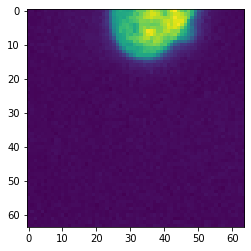

In [113]:
plt.imshow(batch[raw].data)

In [54]:
batch


	RAW_99: ROI: [0:64, 0:64] (64, 64), voxel size: (1, 1), interpolatable: True, non-spatial: False, dtype: uint16, placeholder: False

In [4]:
train_data = zarr.open('./dataset/BBBC039.zarr', 'r')['train_data']

In [6]:
len(train_data)

100

In [23]:
train_data.get(0).attrs['dataspecs']

{'axes': ['y', 'x'],
 'data_spacing': [1, 1],
 'shape': [520, 696],
 'source_file': '/home/tibuch/Data/broad/nuclei_U2OS/images/IXMtest_A06_s6_w1B9577918-4973-4A87-BA73-A168AA755527.tif',
 'target_file': '/home/tibuch/Data/broad/nuclei_U2OS/masks/IXMtest_A06_s6_w1B9577918-4973-4A87-BA73-A168AA755527.tif'}

In [24]:
item = train_data.get(0)

In [29]:
item[0]

<zarr.core.Array '/train_data/0/0' (520, 696) uint16 read-only>

In [201]:
class ZarrDataset(Dataset):
    def __init__(self, path, target_name='nuclei', shape=(64, 64), transform=(gp.RandomLocation() + gp.SimpleAugment())):
        self.path = path
        self.raw = gp.ArrayKey('RAW')
        self.gt = gp.ArrayKey('GT')
        self.request = gp.BatchRequest()
        self.request[self.raw] = gp.Roi((0,) * len(shape), shape)
        self.request[self.gt] = gp.Roi((0,) * len(shape), shape)
        self.pipelines = []
        for i in range(len(zarr.open(path))):            
            source = gp.ZarrSource(
                    path,
                    {self.raw: '{}/0'.format(i)},
                    {self.raw: gp.ArraySpec(interpolatable=True, voxel_size=(1,) * len(shape))}
                )
            
            target = gp.ZarrSource(
                path,
                {self.gt: '{}/labels/{}/0'.format(i, target_name)},
                {self.gt: gp.ArraySpec(interpolatable=False, voxel_size=(1,) * len(shape))}
            )
            
            combined = (source, target) + gp.MergeProvider()
            self.pipelines.append((combined,) + transform)
            
        
    def __len__(self):
        return len(self.pipelines)
    
    def __getitem__(self, idx):
        pipeline = self.pipelines[idx]
        with gp.build(pipeline):
            batch = pipeline.request_batch(self.request)
        return batch[self.raw].data, batch[self.gt].data
        

In [202]:
ds = ZarrDataset('./dataset/BBBC039.zarr/train_data/')

In [208]:
factors = (1, 2)

In [212]:
import numpy as np

In [213]:
np.any(factors != 1)

True

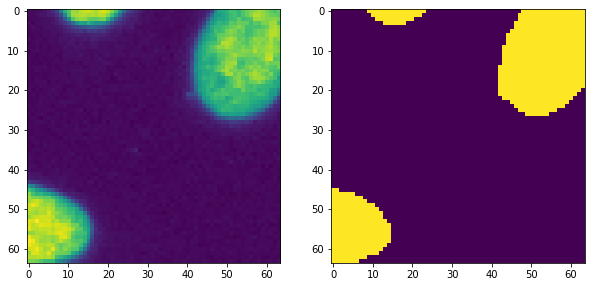

In [207]:
raw, gt = ds.__getitem__(10)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(raw)
plt.subplot(1,2,2)
plt.imshow(gt)

In [214]:
np.unique(gt)

array([0, 1], dtype=uint16)

In [215]:
from skimage.io  import imread

In [216]:
labeling = imread('/home/tibuch/Data/broad/nuclei_U2OS/masks/IXMtest_A02_s1_w1051DAA7C-7042-435F-99F0-1E847D9B42CB.tif')

In [236]:
factors = (0.9, 1.4)

In [237]:
from skimage.transform import rescale

In [238]:
# def rescale_labeling(labeling, factors):
scaled_labeling = rescale(np.zeros_like(labeling), scale=factors)

for l in filter(None, np.unique(labeling)):
    mask = (labeling == l).astype(int)
    
    scaled_mask = rescale(mask, scale=factors, mode='reflect', anti_aliasing=True, preserve_range=True, order=1)
    
    scaled_labeling[scaled_mask > 0.5] = l

In [239]:
from matplotlib.colors import ListedColormap

In [250]:
colors = np.random.rand(255, 4)
colors[0] = 1
cmap = ListedColormap(colors)

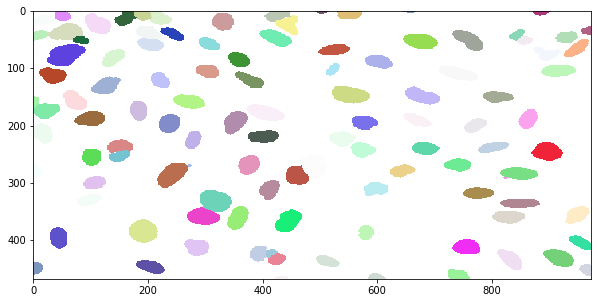

In [251]:
plt.figure(figsize=(10,10))
plt.imshow(scaled_labeling, cmap=cmap, interpolation='nearest')